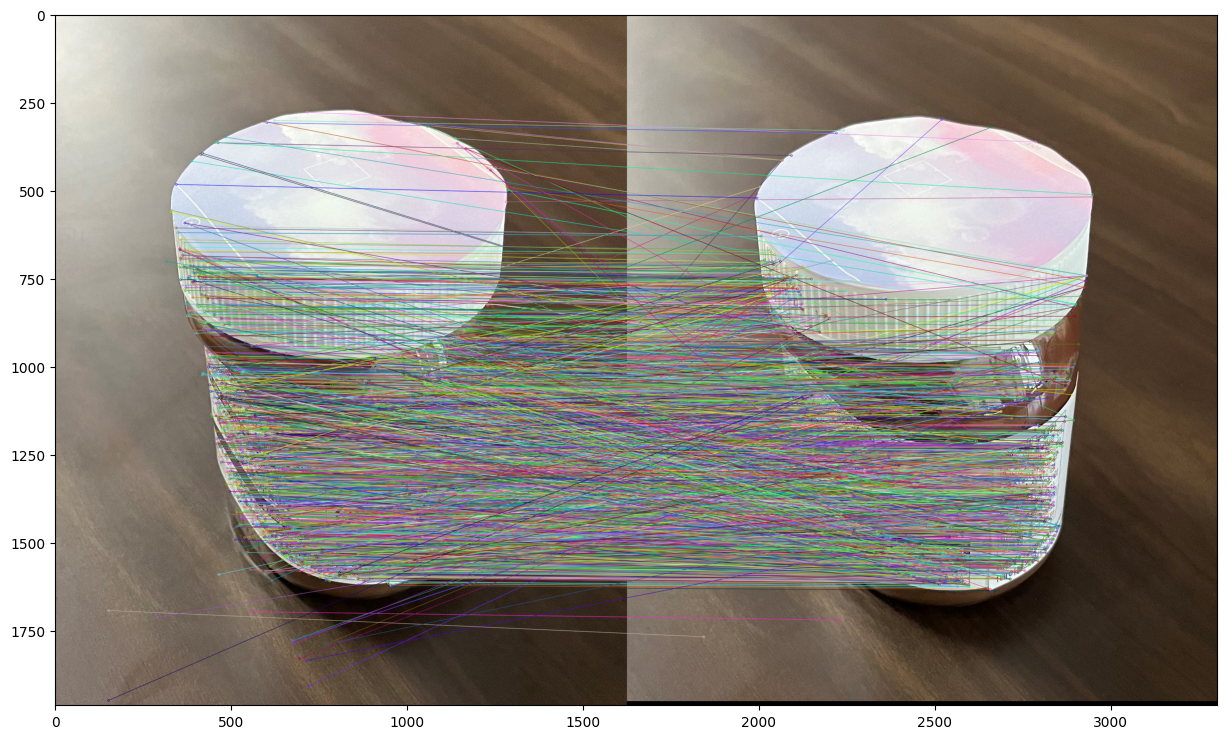

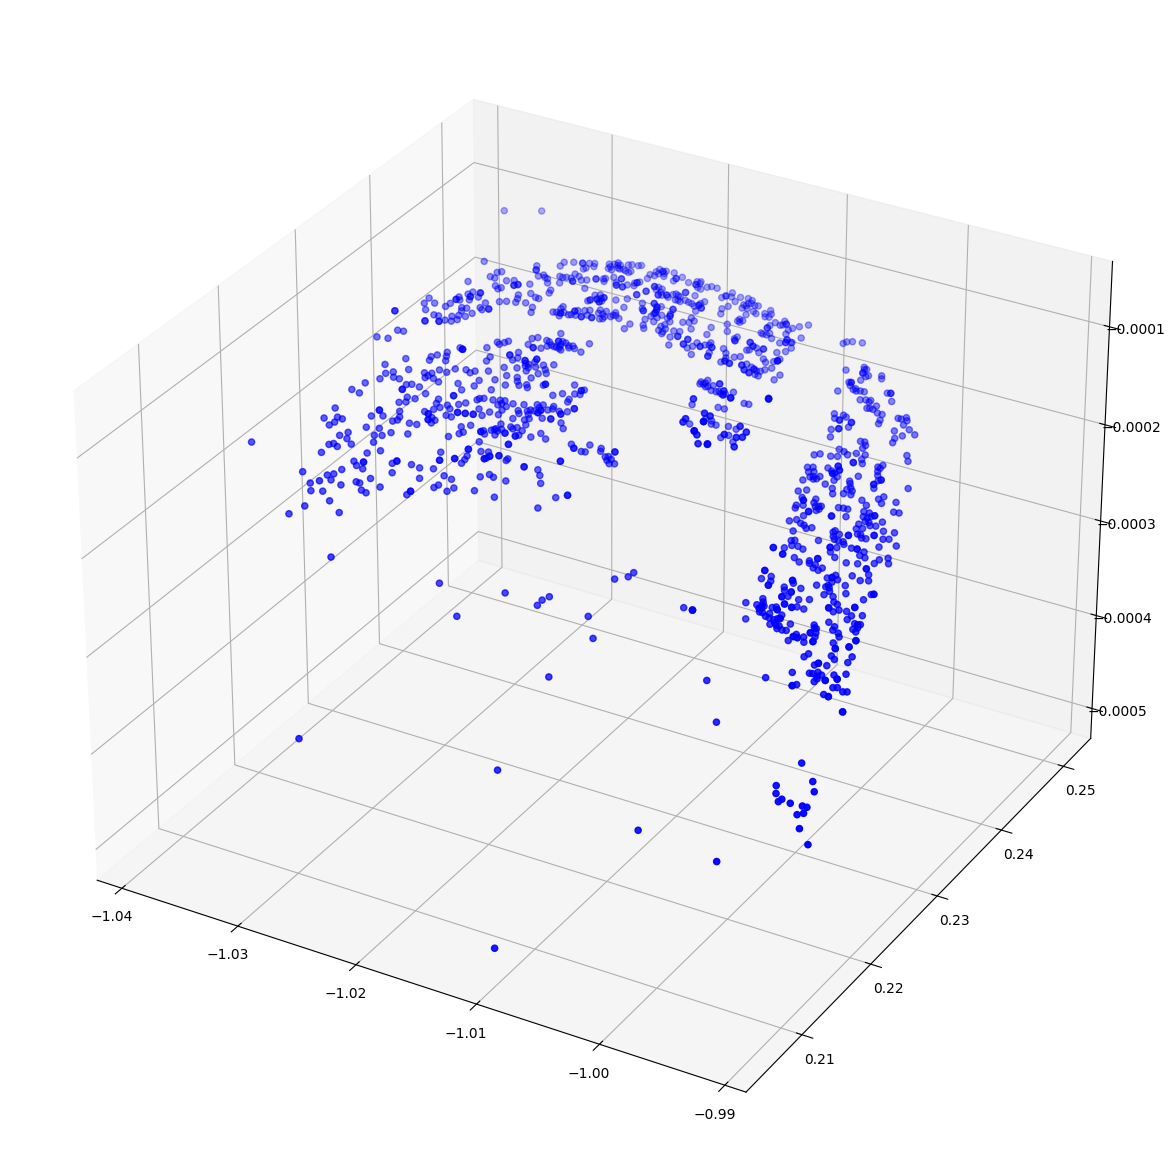

In [10]:
import cv2
import sys
import numpy as np
from matplotlib import pyplot as plt
# from meshplot import plot, subplot, interact

image_directory = './data/nutellar2/'

image1_filename = 'nutella13.jpg'
image2_filename = 'nutella14.jpg'

# Read input images
def read_images(image_directory, image1_filename, image2_filename):
    image1 = cv2.imread(image_directory + image1_filename)
    image2 = cv2.imread(image_directory + image2_filename)
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    return image1, image2

# Detect features and matches using SIFT
def extract_sift_features(image1, image2):
    """Feature detection and description"""
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

    bf_matcher = cv2.BFMatcher()
    raw_matches = bf_matcher.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = [m1 for m1, m2 in raw_matches if m1.distance < 0.95 * m2.distance]
    sorted_matches = sorted(good_matches, key=lambda x: x.distance)
    match_visualization = cv2.drawMatches(image1, keypoints1, image2, keypoints2, sorted_matches, image2, flags=2)
    
    # Display matches
    plt.figure(figsize=(15, 15))
    plt.imshow(match_visualization)
    plt.show()
    return good_matches, keypoints1, keypoints2

# Estimate the Essential Matrix
def estimate_essential_matrix(good_matches, keypoints1, keypoints2):
    """Essential Matrix Computation"""
    query_indices = [match.queryIdx for match in good_matches]
    train_indices = [match.trainIdx for match in good_matches]
    points1 = np.float32([keypoints1[ind].pt for ind in query_indices])  # Pixel coordinates
    points2 = np.float32([keypoints2[ind].pt for ind in train_indices])

    # Compute Essential Matrix using RANSAC and intrinsic camera parameters
    essential_matrix, inlier_mask = cv2.findEssentialMat(points1, points2, method=cv2.RANSAC, focal=3092.8, pp=(2016, 1512), maxIters=500, threshold=1)
    inlier_points1 = points1[inlier_mask.ravel() == 1]
    inlier_points2 = points2[inlier_mask.ravel() == 1]

    return essential_matrix, inlier_points1, inlier_points2

# Decompose the Essential Matrix
def decompose_essential_matrix(essential_matrix, points1, points2):
    """Decomposing Essential Matrix to Possible Camera Poses"""
    selected_camera_matrix = np.array([[]])
    U, S, Vt = np.linalg.svd(essential_matrix, full_matrices=True)
    W = np.array([
        [0, -1, 0],
        [1, 0, 0],
        [0, 0, 1]
    ])

    # Compute four possible camera matrices
    camera_matrices = np.array([
        np.column_stack((U @ W @ Vt, U[:, 2])),
        np.column_stack((U @ W @ Vt, -U[:, 2])),
        np.column_stack((U @ W.T @ Vt, U[:, 2])),
        np.column_stack((U @ W.T @ Vt, -U[:, 2]))
    ])

    # Choose a valid camera matrix based on 3D point reconstruction
    for i in range(4): 
        candidate_matrix = camera_matrices[i]
        for j in range(len(points1)):
            pt1 = points1[j].flatten()
            pt2 = points2[j].flatten()
            concat_points = np.concatenate((pt1, pt2))
            reconstruction = candidate_matrix @ concat_points.T
            if np.any(reconstruction < 0):
                break
            else:
                selected_camera_matrix = candidate_matrix
    return selected_camera_matrix

# Convert points to homogeneous coordinates
def convert_to_homogeneous(points1, points2, count):
    homo_points1 = [[]]
    homo_points2 = [[]]
    for i in range(count):
        tmp1 = np.append(points1[i].flatten(), 1)
        homo_points1 = np.append(homo_points1, tmp1)
        tmp2 = np.append(points2[i].flatten(), 1)
        homo_points2 = np.append(homo_points2, tmp2)
    
    homo_points1 = homo_points1.reshape((count, 3))
    homo_points2 = homo_points2.reshape((count, 3))
    return homo_points1, homo_points2

# Initialize intrinsic and camera matrices
def setup_camera_matrices(camera_matrix):
    identity_rt = np.hstack((np.eye(3), np.zeros((3, 1))))
    skew_param = 0.0215878
    intrinsic_matrix = np.array([[3092.8, skew_param, 2016], [0, 3092.8, 1512], [0, 0, 1]])
    extended_rt = intrinsic_matrix @ camera_matrix
    return identity_rt, extended_rt

# Perform triangulation to generate 3D points
def triangulate_3d_points(rt0, rt1, point1, point2):
    """Generate 3D points from triangulation"""
    equation_system = [
        point1[1] * rt0[2, :] - rt0[1, :],
        -(point1[0] * rt0[2, :] - rt0[0, :]),
        point2[1] * rt1[2, :] - rt1[1, :],
        -(point2[0] * rt1[2, :] - rt1[0, :])
    ]
    equation_system = np.array(equation_system).reshape((4, 4))
    pseudo_solution = equation_system.T @ equation_system
    _, _, Vt = np.linalg.svd(pseudo_solution)
    return Vt[3, 0:3] / Vt[3, 3]

# Generate all 3D points
def compute_3d_points(points1, points2, rt0, rt1):
    points_3d = []
    for pt1, pt2 in zip(points1, points2):
        point_3d = triangulate_3d_points(rt0, rt1, pt1, pt2)
        points_3d.append(point_3d)
    points_3d = np.array(points_3d).T
    return points_3d

# Visualize 3D points
def plot_3d_points(points_3d):
    x_vals, y_vals, z_vals = points_3d[0], points_3d[1], points_3d[2]

    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(projection='3d')
    ax.scatter3D(x_vals, y_vals, z_vals, c='b', marker='o')
    plt.show()



def main():
    img1, img2 = read_images(image_directory, image1_filename, image2_filename)
    matches_good, keypoints1, keypoints2 = extract_sift_features(img1, img2)
    essential_matrix, inliers1, inliers2 = estimate_essential_matrix(matches_good, keypoints1, keypoints2)
    camera_matrix = decompose_essential_matrix(essential_matrix, inliers1, inliers2)
    Rt0, Rt1 = setup_camera_matrices(camera_matrix)
    homo_points1, homo_points2 = convert_to_homogeneous(inliers1, inliers2, len(inliers1))
    points_3d = compute_3d_points(homo_points1, homo_points2, Rt0, Rt1)

    plot_3d_points(points_3d)



if __name__ == "__main__":
    main()

    

